In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

[[-3]
 [ 3]]


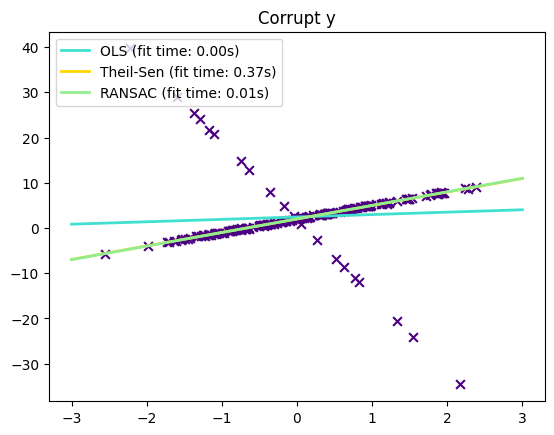

In [7]:
# Author: Florian Wilhelm -- <florian.wilhelm@gmail.com>
# License: BSD 3 clause

import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression, RANSACRegressor, TheilSenRegressor

estimators = [
    ("OLS", LinearRegression()),
    ("Theil-Sen", TheilSenRegressor(random_state=42)),
    ("RANSAC", RANSACRegressor(random_state=42)),
]
colors = {"OLS": "turquoise", "Theil-Sen": "gold", "RANSAC": "lightgreen"}
lw = 2

np.random.seed(0)
n_samples = 200
# Linear model y = 3*x + N(2, 0.1**2)
x = np.random.randn(n_samples)
w = 3.0
c = 2.0
noise = 0.1 * np.random.randn(n_samples)
y = w * x + c + noise
# 10% outliers
y[-20:] += -20 * x[-20:]
X = x[:, np.newaxis]

plt.scatter(x, y, color="indigo", marker="x", s=40)
line_x = np.array([-3, 3])
print(line_x.reshape(2,1))
for name, estimator in estimators:
    t0 = time.time()
    estimator.fit(X, y)
    elapsed_time = time.time() - t0
    y_pred = estimator.predict(line_x.reshape(2, 1))
    plt.plot(
        line_x,
        y_pred,
        color=colors[name],
        linewidth=lw,
        label="%s (fit time: %.2fs)" % (name, elapsed_time),
    )

plt.axis("tight")
plt.legend(loc="upper left")
_ = plt.title("Corrupt y")

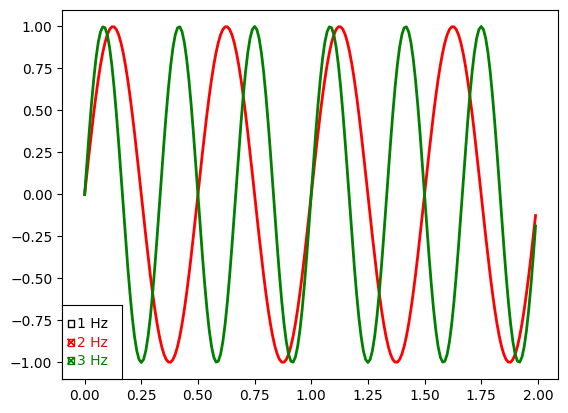

8.280693249699723 73.87570019829454 [156.03209364628879, -139.47070714688937]


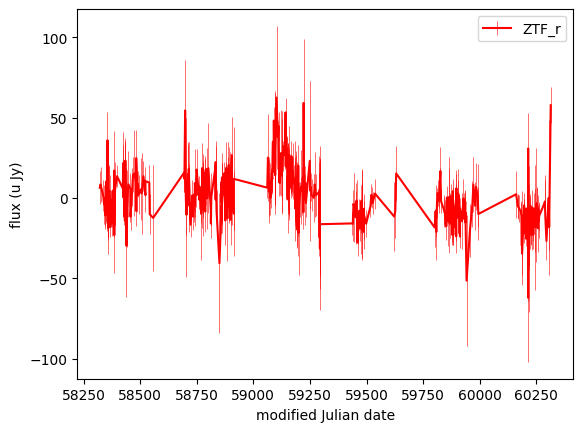

17.604624993453125 110.290361057151 [238.18534710775512, -202.9760971208489]


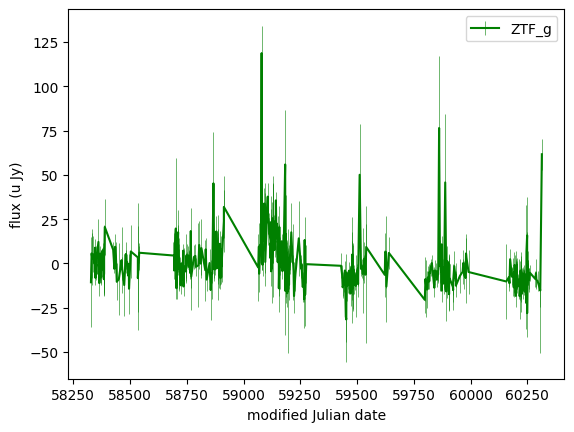

-7.097924558934314 52.58846238403531 [98.07900020913631, -112.27484932700493]


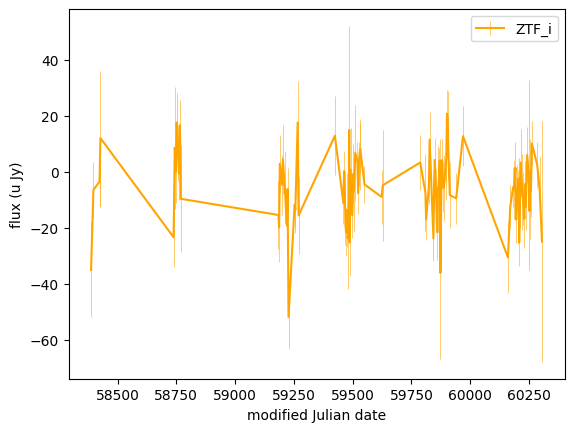

In [44]:
# import and process data
data_path="hero.csv"
df = pd.read_csv(data_path) 

ZTF_bands=df[df['filter'].str.contains('ZTF')]['filter'].unique()   # different bands from the ZTF data

ZTF={}  # dictionary for lists of ZTF data in each band
T={}    # dictionary for lists of ZTF timeseries in each band
ERR={}  # dictionary for lists of uncertainities 

colors=['r', 'g', 'orange'] # colors for plotting

sigflux_threshold=50    # threshold to eliminates data points with high uncertainty
outliers_threshold =2   # no of stdevs to eliminate outliers


# store flux data in the corresponding ZTF list and plot
for i in range(len(ZTF_bands)):

    cur_df = df[df['filter']==ZTF_bands[i]]     # choose a single ZTF band
    cur_df = cur_df[cur_df['sigflux']<=sigflux_threshold]     # retrieve data points with error<=100 micro Jansky
    
    # filter outliers 
    mean = np.mean(cur_df['flux'])
    std= np.std(cur_df['flux'])

    threshold = [mean + outliers_threshold* std, mean-outliers_threshold*std]
    print(mean, std, threshold)
    
    cur_df=cur_df[(cur_df.flux<=threshold[0])&(cur_df.flux>=threshold[1])]
    
    # store data points
    ZTF[ZTF_bands[i]]=np.array(cur_df['flux'])
    T[ZTF_bands[i]]=np.array(cur_df['mjd'])
    ERR[ZTF_bands[i]]=np.array(cur_df['sigflux'])

    # plot
    plt.errorbar(
        cur_df['mjd'],
        cur_df['flux'],
        cur_df['sigflux'],
        #linestyle="None",
        ecolor=colors[i],
        elinewidth=0.4,
        #marker='v',
        c=colors[i],
        #linewidth=0
    )
    plt.xlabel('modified Julian date')
    plt.ylabel('flux (u Jy)')
    plt.legend([ZTF_bands[i]])
    plt.savefig(ZTF_bands[i]+".png")
    plt.show()    

In [53]:

def GP(band, i):
    kernel = 1 * Matern(nu=1.5, length_scale=1, length_scale_bounds=(1e-9, 1e9))
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=np.square(ERR[band]) )
    gaussian_process.fit( T[band].reshape(-1,1), ZTF[band])
    print(gaussian_process.kernel_)

    time_series=np.linspace(58250, 60500,1000).reshape(-1,1)

    mean_prediction, std_prediction = gaussian_process.predict(time_series, return_std=True)

    plt.errorbar(
            T[band],
            ZTF[band],
            ERR[band],
            linestyle="None",
            ecolor=colors[i],
            elinewidth=0.4,
            #marker='_',
            c=colors[i],
            #linewidth=0
        )
    plt.plot(time_series, mean_prediction, label="Mean prediction "+band)
    plt.fill_between(
        time_series.ravel(),
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    plt.legend()
    plt.xlabel("modified Julian date")
    #plt.xlim(59200, 59300)
    plt.ylabel("Flux (uJy)")
    plt.show()


9.71**2 * Matern(length_scale=33, nu=1.5)


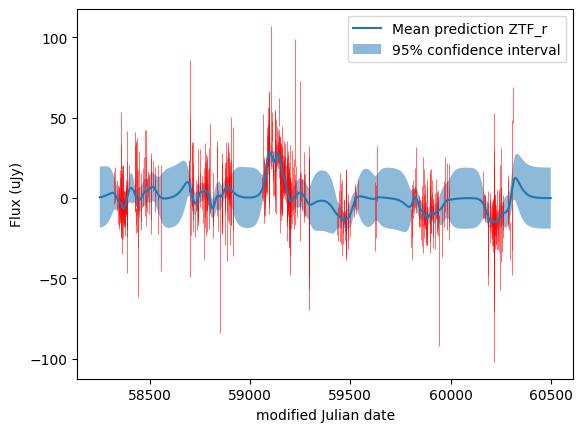

7.05**2 * Matern(length_scale=20.7, nu=1.5)


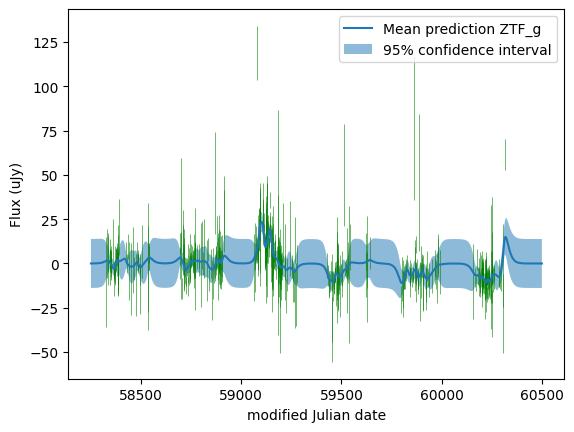

7.35**2 * Matern(length_scale=34.7, nu=1.5)


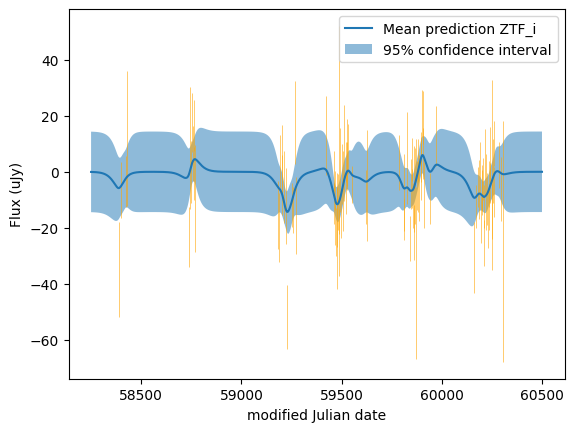

In [54]:

for (i, band) in enumerate(ZTF_bands):
    GP(band, i)